<img src="https://w2.solucaoatrio.net.br/somos/upe-ppgec/templates/jsn_solid_pro/images/colors/red/logo-v3.png" alt="logo-poli-ecomp" width="700" height="250">

**Programa de Pós-Graduação em Engenharia da Computação da Universidade de Pernambuco**

**Disciplina:** Reconhecimento de Padrões

**Docente:** João Fausto Lorenzato de Oliveira

**Discentes:** José Vogeley Alves de Sá e Thiago Brito Cassimiro da Silva

**Recife, 30 de junho de 2025**

# Projeto Final - Detecção Otimizada de Fraude com Cartão de Crédito: Um Sistema Híbrido em Cascata SVM-XGBoost Focado no Refinamento de Predições

Este projeto faz parte do escopo avaliativo da disciplina de Reconhecimento de Padrões. O objetivo geral proposto pelo docente para este projeto é que deve envolver a implementação de um sistema híbrido e sua avaliação comparativa com o estado da arte.

> Hipotese proposta: Um sistema híbrido de classificação em cascata, onde um Support Vector Machine (SVM) atua como classificador primário e um XGBoost subsequente refina as predições de baixa confiança ou corrige os erros do SVM, apresentará um desempenho preditivo estatisticamente superior e mais robusto na detecção de fraude de cartão de crédito (com foco em métricas como F1-score e recall para a classe minoritária), quando comparado aos sistemas híbridos de estado da arte propostos na literatura para o mesmo domínio e dataset.

## Sistemas e Métodos Propostos na Literatura

### A Hybrid Machine Learning Approach for Credit Card Fraud Detection

- Disponível em: https://www.researchgate.net/publication/365139622_A_Hybrid_Machine_Learning_Approach_for_Credit_Card_Fraud_Detection
- Modelo proposto: Ensemble (Multilayer Perceptron, XGBoost e Logistic Regression)

#### Tentativa 1

##### Leitura e Pré-processamento dos Dados

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

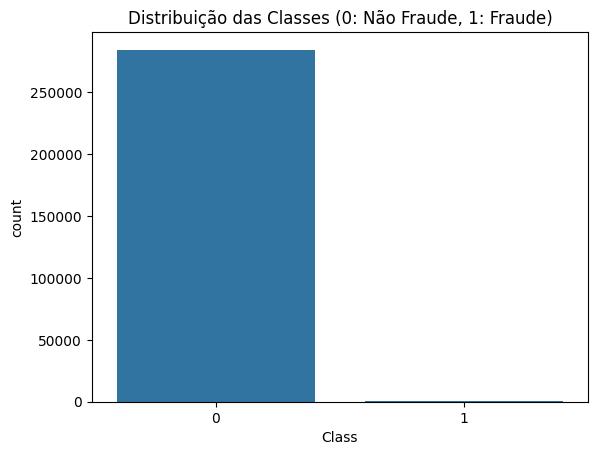

In [ ]:
# Carregar o dataset
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# Visualizar as primeiras linhas
print(df.head())

# Verificar a distribuição das classes
print(df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title('Distribuição das Classes (0: Não Fraude, 1: Fraude)')
plt.show()

In [ ]:
# print(f"Percentual de NÃO fraude: {int(df['Class'].where(df['Class'] == 0).value_counts()) / int(df['Class'].value_counts())}")
# print(f"Percentual de fraude: {int(df['Class'].where(df['Class'] == 1).value_counts()) / int(df['Class'].value_counts())}")

In [ ]:
# Normalização das Features 'Time' e 'Amount'
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Remover as colunas originais
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [ ]:
# Divisão em Conjuntos de Treino e Teste
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print("Distribuição das classes antes do SMOTE:", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribuição das classes depois do SMOTE:", y_train_res.value_counts())

Distribuição das classes antes do SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
Distribuição das classes depois do SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


##### Treinamento dos Modelos

In [ ]:
# Regressão Logística
lr_clf = LogisticRegression(random_state=42, solver='liblinear')
lr_clf.fit(X_train_res, y_train_res)

# XGBoost (Extreme Gradient Boosting)
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_res, y_train_res)

# Multilayer Perceptron (MLP)
mlp_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_clf.fit(X_train_res, y_train_res)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

In [ ]:
# Criação e Treinamento do Modelo de Ensemble (Voting Classifier)
# Criar o ensemble com votação soft
ensemble_clf = VotingClassifier(estimators=[('lr', lr_clf), ('xgb', xgb_clf), ('mlp', mlp_clf)], voting='hard')

# Treinar o modelo de ensemble
ensemble_clf.fit(X_train_res, y_train_res)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(64, 32),
                                            max_iter=500, random_state=42))])

##### Avaliação do Modelo

Relatório de Classificação do Modelo Ensemble:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.89      0.78        98

    accuracy                           1.00     56962
   macro avg       0.85      0.94      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Acurácia: 0.9992
Precisão: 0.7016
Recall: 0.8878
F1-Score: 0.7838


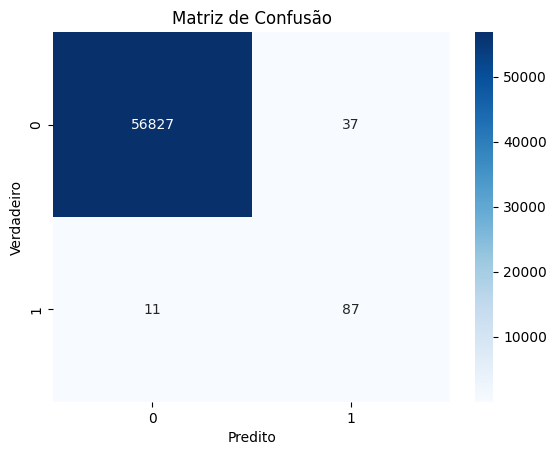

In [ ]:
# Fazer predições no conjunto de teste
y_pred = ensemble_clf.predict(X_test)

# Gerar o relatório de classificação
print("Relatório de Classificação do Modelo Ensemble:")
print(classification_report(y_test, y_pred))

# Calcular e imprimir as métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

#### Tentativa 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- CARREGAMENTO E PRÉ-PROCESSAMENTO INICIAL ---

# Carregar o dataset
try:
    df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
except FileNotFoundError:
    print("Erro: O arquivo '/kaggle/input/creditcardfraud/creditcard.csv' não foi encontrado.")
    print("Por favor, baixe o dataset do Kaggle: https://www.kaggle.com/datasets/mlg-ulb/credit-card-fraud-detection")
    # Encerra a execução se o arquivo não for encontrado
    exit()


# Normalizar as colunas 'Time' e 'Amount'
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Remover as colunas originais e mover 'Class' para o final se necessário
df.drop(['Time', 'Amount'], axis=1, inplace=True)
# Reordenando para ter a variável alvo por último (opcional, boa prática)
cols = list(df.columns)
cols.remove('Class')
df = df[cols + ['Class']]


# --- DIVISÃO EM DADOS DE TREINO E TESTE ---
# Esta divisão é feita ANTES do balanceamento para garantir que o conjunto de teste
# permaneça com a distribuição original do mundo real.

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("--- ESTRUTURA DOS DADOS ---")
print(f"Formato do X_train: {X_train.shape}")
print(f"Formato do X_test: {X_test.shape}")
print(f"Distribuição das classes no conjunto de treino original:\n{y_train.value_counts()}")
print(f"Distribuição das classes no conjunto de teste:\n{y_test.value_counts()}")
print("-" * 40)

--- ESTRUTURA DOS DADOS ---
Formato do X_train: (227845, 30)
Formato do X_test: (56962, 30)
Distribuição das classes no conjunto de treino original:
Class
0    227451
1       394
Name: count, dtype: int64
Distribuição das classes no conjunto de teste:
Class
0    56864
1       98
Name: count, dtype: int64
----------------------------------------



--- ABORDAGEM 1: TREINAMENTO COM DATASET DESBALANCEADO ---
Treinando modelos no dataset desbalanceado...
Tempo de treinamento: 59.50 segundos

--- AVALIAÇÃO NO DATASET DESBALANCEADO ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Acurácia (Desbalanceado): 0.9994
Precisão (Desbalanceado): 0.8511
Recall (Desbalanceado): 0.8163
F1-Score (Desbalanceado): 0.8333


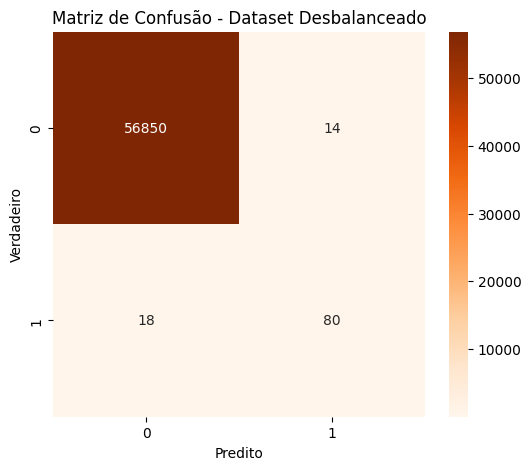

----------------------------------------


In [ ]:
print("\n--- ABORDAGEM 1: TREINAMENTO COM DATASET DESBALANCEADO ---")

# --- DEFINIÇÃO DOS MODELOS ---
lr_clf_imb = LogisticRegression(random_state=42, solver='liblinear')
xgb_clf_imb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
mlp_clf_imb = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)

# O ensemble
ensemble_clf_imb = VotingClassifier(
    estimators=[('lr', lr_clf_imb), ('xgb', xgb_clf_imb), ('mlp', mlp_clf_imb)],
    voting='hard'
)

# --- TREINAMENTO ---
print("Treinando modelos no dataset desbalanceado...")
start_time = time()
ensemble_clf_imb.fit(X_train, y_train)
end_time = time()
print(f"Tempo de treinamento: {end_time - start_time:.2f} segundos")


# --- AVALIAÇÃO ---
print("\n--- AVALIAÇÃO NO DATASET DESBALANCEADO ---")
y_pred_imb = ensemble_clf_imb.predict(X_test)

accuracy_imb = accuracy_score(y_test, y_pred_imb)
precision_imb = precision_score(y_test, y_pred_imb)
recall_imb = recall_score(y_test, y_pred_imb)
f1_imb = f1_score(y_test, y_pred_imb)

print(classification_report(y_test, y_pred_imb))
print(f"Acurácia (Desbalanceado): {accuracy_imb:.4f}")
print(f"Precisão (Desbalanceado): {precision_imb:.4f}")
print(f"Recall (Desbalanceado): {recall_imb:.4f}")
print(f"F1-Score (Desbalanceado): {f1_imb:.4f}")

# Matriz de Confusão
cm_imb = confusion_matrix(y_test, y_pred_imb)
plt.figure(figsize=(6,5))
sns.heatmap(cm_imb, annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusão - Dataset Desbalanceado')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()
print("-" * 40)


--- ABORDAGEM 2: TREINAMENTO COM DATASET BALANCEADO (SMOTE) ---
Aplicando SMOTE ao conjunto de treinamento...
Distribuição das classes depois do SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64

Treinando modelos no dataset balanceado...
Tempo de treinamento: 110.60 segundos

--- AVALIAÇÃO NO DATASET BALANCEADO ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.89      0.78        98

    accuracy                           1.00     56962
   macro avg       0.85      0.94      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Acurácia (Balanceado): 0.9992
Precisão (Balanceado): 0.7016
Recall (Balanceado): 0.8878
F1-Score (Balanceado): 0.7838


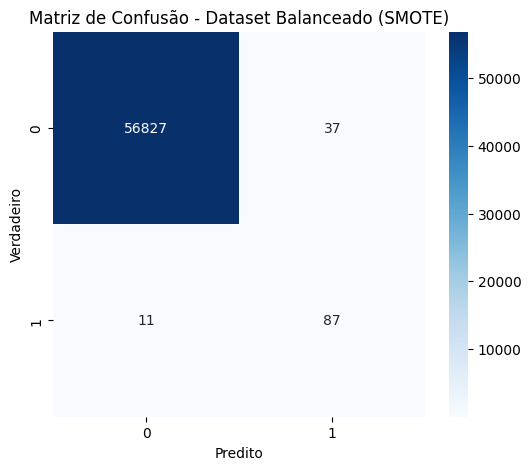

----------------------------------------


In [ ]:
print("\n--- ABORDAGEM 2: TREINAMENTO COM DATASET BALANCEADO (SMOTE) ---")

# --- APLICAÇÃO DO SMOTE ---
print("Aplicando SMOTE ao conjunto de treinamento...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribuição das classes depois do SMOTE:", y_train_res.value_counts())

# --- DEFINIÇÃO DOS MODELOS ---
lr_clf_bal = LogisticRegression(random_state=42, solver='liblinear')
xgb_clf_bal = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
mlp_clf_bal = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)

# O ensemble
ensemble_clf_bal = VotingClassifier(
    estimators=[('lr', lr_clf_bal), ('xgb', xgb_clf_bal), ('mlp', mlp_clf_bal)],
    voting='hard'
)

# --- TREINAMENTO ---
print("\nTreinando modelos no dataset balanceado...")
start_time = time()
ensemble_clf_bal.fit(X_train_res, y_train_res)
end_time = time()
print(f"Tempo de treinamento: {end_time - start_time:.2f} segundos")

# --- AVALIAÇÃO ---
print("\n--- AVALIAÇÃO NO DATASET BALANCEADO ---")
y_pred_bal = ensemble_clf_bal.predict(X_test)

accuracy_bal = accuracy_score(y_test, y_pred_bal)
precision_bal = precision_score(y_test, y_pred_bal)
recall_bal = recall_score(y_test, y_pred_bal)
f1_bal = f1_score(y_test, y_pred_bal)

print(classification_report(y_test, y_pred_bal))
print(f"Acurácia (Balanceado): {accuracy_bal:.4f}")
print(f"Precisão (Balanceado): {precision_bal:.4f}")
print(f"Recall (Balanceado): {recall_bal:.4f}")
print(f"F1-Score (Balanceado): {f1_bal:.4f}")

# Matriz de Confusão
cm_bal = confusion_matrix(y_test, y_pred_bal)
plt.figure(figsize=(6,5))
sns.heatmap(cm_bal, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Dataset Balanceado (SMOTE)')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()
print("-" * 40)

In [ ]:
# --- COMPARAÇÃO FINAL ---

results = {
    'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score'],
    'Dataset Desbalanceado': [accuracy_imb, precision_imb, recall_imb, f1_imb],
    'Dataset Balanceado (SMOTE)': [accuracy_bal, precision_bal, recall_bal, f1_bal]
}

results_df = pd.DataFrame(results)
results_df['Dataset Desbalanceado'] = results_df['Dataset Desbalanceado'].map('{:.4f}'.format)
results_df['Dataset Balanceado (SMOTE)'] = results_df['Dataset Balanceado (SMOTE)'].map('{:.4f}'.format)

print("\n--- TABELA COMPARATIVA DE RESULTADOS ---")
print(results_df.to_string(index=False))


--- TABELA COMPARATIVA DE RESULTADOS ---
 Métrica Dataset Desbalanceado Dataset Balanceado (SMOTE)
Acurácia                0.9994                     0.9992
Precisão                0.8511                     0.7016
  Recall                0.8163                     0.8878
F1-Score                0.8333                     0.7838


#### Tentativa 3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings

# --- Configurações Iniciais ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Bibliotecas de Machine Learning ---
# Pré-processamento e Pipelines
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Modelos
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

# Validação e Métricas
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- 1. CARREGAMENTO E PRÉ-PROCESSAMENTO INICIAL ---

print("Carregando e pré-processando os dados...")
try:
    df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
except FileNotFoundError:
    print("Erro: O arquivo '/kaggle/input/creditcardfraud/creditcard.csv' não foi encontrado.")
    print("Por favor, baixe o dataset do Kaggle: https://www.kaggle.com/datasets/mlg-ulb/credit-card-detection")
    exit()

# O artigo especifica um pipeline de scaling para 'Time' e 'Amount'
# 1. RobustScaler (para lidar com outliers) -> 2. StandardScaler (para normalizar)
scaling_pipeline = SklearnPipeline([
    ('robust', RobustScaler()),
    ('standard', StandardScaler())
])

df[['Time', 'Amount']] = scaling_pipeline.fit_transform(df[['Time', 'Amount']])

# Separar features (X) e alvo (y)
X = df.drop('Class', axis=1)
y = df['Class']

print("Pré-processamento inicial concluído.")
print("-" * 50)


# --- 2. DEFINIÇÃO DOS MODELOS E VALIDAÇÃO CRUZADA ---

# Estratégia de Validação Cruzada conforme o artigo (5 dobras)
cv_strategy = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Dicionário para armazenar os resultados finais
final_results = {}

# Função auxiliar para avaliar os modelos com validação cruzada
def evaluate_model_with_cv(model, X, y, cv, model_name="Modelo"):
    """
    Treina e avalia um modelo usando validação cruzada.
    Retorna a média das métricas de desempenho.
    """
    print(f"Avaliando {model_name}...")
    start_time = time()

    accuracies, precisions, recalls, f1s = [], [], [], []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        # Separar dados para esta dobra
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        # Treinar o modelo
        model.fit(X_train_fold, y_train_fold)

        # Fazer predições
        y_pred_fold = model.predict(X_test_fold)

        # Armazenar métricas
        accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
        precisions.append(precision_score(y_test_fold, y_pred_fold))
        recalls.append(recall_score(y_test_fold, y_pred_fold))
        f1s.append(f1_score(y_test_fold, y_pred_fold))

        print(f"  Fold {fold+1}/5 -> Recall: {recalls[-1]:.4f}")

    end_time = time()
    print(f"Tempo total de avaliação: {end_time - start_time:.2f} segundos\n")

    # Retornar a média das métricas
    return {
        "Acurácia": np.mean(accuracies),
        "Precisão": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s)
    }

# --- 3. ABORDAGEM 1: DATASET DESBALANCEADO ---

print("--- ABORDAGEM 1: AVALIAÇÃO COM DATASET DESBALANCEADO ---")
# Definir os modelos base
lr_clf_imb = LogisticRegression(random_state=42, solver='liblinear', class_weight=None)
xgb_clf_imb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
mlp_clf_imb = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)

# Criar o ensemble para o cenário desbalanceado
ensemble_imb = VotingClassifier(
    estimators=[('lr', lr_clf_imb), ('xgb', xgb_clf_imb), ('mlp', mlp_clf_imb)],
    voting='hard'
)

# Avaliar o modelo ensemble desbalanceado
results_imb = evaluate_model_with_cv(ensemble_imb, X, y, cv_strategy, "Ensemble Desbalanceado")
final_results['Dataset Desbalanceado'] = results_imb
print("-" * 50)


# --- 4. ABORDAGEM 2: DATASET BALANCEADO (COM SMOTE EM PIPELINE) ---

print("--- ABORDAGEM 2: AVALIAÇÃO COM DATASET BALANCEADO (SMOTE) ---")
# Para esta abordagem, criamos um pipeline para cada classificador.
# O pipeline primeiro aplica o SMOTE e depois treina o classificador.
# Isso garante que o SMOTE seja aplicado apenas nos dados de treino de cada fold.

# Pipeline para Regressão Logística
lr_pipe_bal = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Pipeline para XGBoost
xgb_pipe_bal = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Pipeline para MLP
mlp_pipe_bal = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42))
])


# Criar o ensemble para o cenário balanceado usando os pipelines
ensemble_bal = VotingClassifier(
    estimators=[('lr_pipe', lr_pipe_bal), ('xgb_pipe', xgb_pipe_bal), ('mlp_pipe', mlp_pipe_bal)],
    voting='hard'
)

# Avaliar o modelo ensemble balanceado
results_bal = evaluate_model_with_cv(ensemble_bal, X, y, cv_strategy, "Ensemble Balanceado (SMOTE)")
final_results['Dataset Balanceado (SMOTE)'] = results_bal
print("-" * 50)


# --- 5. COMPARAÇÃO FINAL DOS RESULTADOS ---

print("\n--- TABELA COMPARATIVA DE RESULTADOS (MÉDIA DE 5 FOLDS) ---")

# Criar um DataFrame a partir do dicionário de resultados
results_df = pd.DataFrame(final_results).T  # Transpor para ter os cenários como linhas
results_df = results_df[['Acurácia', 'Precisão', 'Recall', 'F1-Score']] # Reordenar colunas

# Formatar os valores
for col in results_df.columns:
    results_df[col] = results_df[col].map('{:.4f}'.format)

print(results_df)

Carregando e pré-processando os dados...
Pré-processamento inicial concluído.
--------------------------------------------------
--- ABORDAGEM 1: AVALIAÇÃO COM DATASET DESBALANCEADO ---
Avaliando Ensemble Desbalanceado...
  Fold 1/5 -> Recall: 0.7653
  Fold 2/5 -> Recall: 0.7449
  Fold 3/5 -> Recall: 0.8673
  Fold 4/5 -> Recall: 0.7959
  Fold 5/5 -> Recall: 0.7449
Tempo total de avaliação: 304.77 segundos

--------------------------------------------------
--- ABORDAGEM 2: AVALIAÇÃO COM DATASET BALANCEADO (SMOTE) ---
Avaliando Ensemble Balanceado (SMOTE)...
  Fold 1/5 -> Recall: 0.8878
  Fold 2/5 -> Recall: 0.8469
  Fold 3/5 -> Recall: 0.9184
  Fold 4/5 -> Recall: 0.8571
  Fold 5/5 -> Recall: 0.8571
Tempo total de avaliação: 535.37 segundos

--------------------------------------------------

--- TABELA COMPARATIVA DE RESULTADOS (MÉDIA DE 5 FOLDS) ---
                           Acurácia Precisão  Recall F1-Score
Dataset Desbalanceado        0.9995   0.9414  0.7837   0.8545
Dataset Bala

### Detection of Credit Card Fraud using a Hybrid Ensemble Model

- Disponível em: https://www.researchgate.net/publication/364127788_Detection_of_Credit_Card_Fraud_using_a_Hybrid_Ensemble_Model
- Modelo proposto: Ensemble (Adaboost,  Random Forest e Logistic regression)

#### Tentativa 1

In [4]:
# 1. Importações essenciais
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# 2. Carregamento do dataset
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
X = df.drop('Class', axis=1)
y = df['Class']

# 3. Pré-processamento: escala das variáveis Time e Amount
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# 4. Divisão treino/teste antes do SMOTE (importante para evitar vazamento de dados)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 5. Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print(f"Distribuição após SMOTE: {np.bincount(y_train_sm)}")

# 6. Modelos
rf = RandomForestClassifier(n_estimators=100, random_state=42)
ada = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=42)

# 7. Treinamento do Random Forest
rf.fit(X_train_sm, y_train_sm)

# 8. Previsão com RF (probabilidades para input no AdaBoost)
rf_preds_train = rf.predict_proba(X_train_sm)[:, 1].reshape(-1, 1)

# 9. Treinamento do AdaBoost com as saídas do RF
ada.fit(rf_preds_train, y_train_sm)

# 10. Teste do modelo híbrido
rf_preds_test = rf.predict_proba(X_test)[:, 1].reshape(-1, 1)
y_pred = ada.predict(rf_preds_test)

# 11. Avaliação
print("Acurácia:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calcular e imprimir as métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Distribuição após SMOTE: [199020 199020]
Acurácia: 0.9994382219725431
ROC AUC: 0.8850530670185984
Confusion Matrix:
 [[85281    14]
 [   34   114]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.77      0.83       148

    accuracy                           1.00     85443
   macro avg       0.95      0.89      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Acurácia: 0.9994
Precisão: 0.8906
Recall: 0.7703
F1-Score: 0.8261


### Securing transactions: a hybrid dependable ensemble machine learning model using IHT-LR and grid search

- Disponível em: https://cybersecurity.springeropen.com/articles/10.1186/s42400-024-00221-z
- Modelo proposto: Ensemble (Decision Trees, Random Forests, k-nearest Neighbors, and Multilayer Perceptron)

#### Tentativa 1

In [7]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.under_sampling import InstanceHardnessThreshold
import warnings
warnings.filterwarnings('ignore')

# 2. Carregar dataset
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df = df.dropna()  # remover nulos
X = df.drop('Class', axis=1)
y = df['Class']

# 3. Pré-processamento
# padronização de variáveis numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# label encoding de target (se necessário)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 4. Tratamento de desequilíbrio com IHT-LR
lr = LogisticRegression(max_iter=1000, random_state=42)
iht = InstanceHardnessThreshold(estimator=lr, sampling_strategy='majority', random_state=42)
X_bal, y_bal = iht.fit_resample(X_scaled, y_enc)
print("Distribuição balanceada:", np.bincount(y_bal))

# 5. Definição dos modelos base
models = {
    'dt': DecisionTreeClassifier(random_state=42),
    'rf': RandomForestClassifier(n_estimators=100, random_state=42),
    'knn': KNeighborsClassifier(),
    'mlp': MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, random_state=42)
}

# 6. Estrutura do VotingClassifier com pesos variáveis
ensemble = VotingClassifier(
    estimators=[(k, v) for k, v in models.items()],
    voting='soft'
)

# 7. Grid de pesos (exemplo para soma=1)
param_grid = {
    'weights': [
        [0.25, 0.25, 0.25, 0.25],
        [0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4],
    ]
}

# 8. Validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    ensemble, param_grid,
    cv=cv, scoring='roc_auc', n_jobs=-1
)
grid.fit(X_bal, y_bal)

print("Melhores pesos:", grid.best_params_, "AUC:", grid.best_score_)

# 9. Avaliação final com cross‑val + métricas
best = grid.best_estimator_
scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[], 'roc_auc':[]}

for train_idx, test_idx in cv.split(X_bal, y_bal):
    X_tr, X_te = X_bal[train_idx], X_bal[test_idx]
    y_tr, y_te = y_bal[train_idx], y_bal[test_idx]
    best.fit(X_tr, y_tr)
    y_pred = best.predict(X_te)
    y_prob = best.predict_proba(X_te)[:, 1]
    scores['accuracy'].append(accuracy_score(y_te, y_pred))
    scores['precision'].append(precision_score(y_te, y_pred))
    scores['recall'].append(recall_score(y_te, y_pred))
    scores['f1'].append(f1_score(y_te, y_pred))
    scores['roc_auc'].append(roc_auc_score(y_te, y_prob))

# print({m: np.mean(v) for m, v in scores.items()})
for model, value in scores.items():
    # print(f'{model}: {np.mean(value)}')
    print(f'{model}: {float(np.mean(value)):.4f}')

Distribuição balanceada: [492 492]
Melhores pesos: {'weights': [0.25, 0.25, 0.25, 0.25]} AUC: 1.0
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
roc_auc: 1.0


## Modelo Proposto

### Testes

In [1]:
%pip install kaggle pandas numpy xgboost matplotlib seaborn scikit-learn

In [ ]:
# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


PASSO 1: Carregando dados e aplicando engenharia de features...
PASSO 2: Normalizando e dividindo os dados em treino, validação e teste...
PASSO 3: Treinando modelo base (SVM) com Stacking Generalization...
PASSO 4: Treinando o meta-learner (XGBoost) com SMOTE via Pipeline...
PASSO 5: Otimizando o limiar de decisão usando o conjunto de validação...
Melhor limiar encontrado para maximizar o F1-Score: 0.9927
PASSO 6: Realizando a avaliação final no conjunto de teste...

==== RELATÓRIO DE CLASSIFICAÇÃO FINAL ====

              precision    recall  f1-score   support

      Normal     0.9995    0.9999    0.9997     42648
      Fraude     0.9464    0.7162    0.8154        74

    accuracy                         0.9994     42722
   macro avg     0.9730    0.8581    0.9076     42722
weighted avg     0.9994    0.9994    0.9994     42722


==== AUC-ROC ====
AUC: 0.9576



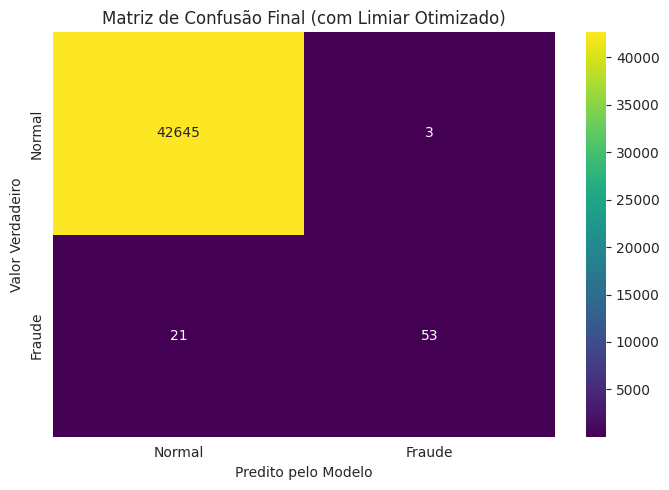

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Configurações Iniciais ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_style('whitegrid')

# --- Bibliotecas de Machine Learning ---
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# =====================================================================================
# PASSO 1: CARREGAMENTO E ENGENHARIA DE FEATURES
# =====================================================================================
print("PASSO 1: Carregando dados e aplicando engenharia de features...")

df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

# Engenharia de Features Cíclicas para a coluna 'Time'
seconds_in_day = 86400  # 24 horas * 60 minutos * 60 segundos
df['time_sin'] = np.sin(2 * np.pi * df['Time'] / seconds_in_day)
df['time_cos'] = np.cos(2 * np.pi * df['Time'] / seconds_in_day)
df.drop('Time', axis=1, inplace=True)


# =====================================================================================
# PASSO 2: PRÉ-PROCESSAMENTO E DIVISÃO DOS DADOS
# =====================================================================================
print("PASSO 2: Normalizando e dividindo os dados em treino, validação e teste...")

# A coluna 'Amount' ainda precisa ser normalizada
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Separando features (X) e alvo (y)
X = df.drop("Class", axis=1)
y = df["Class"]

# Divisão Estratificada em 3 conjuntos: Treino (70%), Validação (15%) e Teste (15%)
# Primeiro, dividimos em treino (70%) e um conjunto temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Dividimos o conjunto temporário igualmente em validação e teste (15% cada do total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


# =====================================================================================
# PASSO 3: STACKING (MODELO BASE) - GERANDO FEATURES COM SVM
# =====================================================================================
print("PASSO 3: Treinando modelo base (SVM) com Stacking Generalization...")

# Para este exemplo, usamos parâmetros fixos para o SVM para agilizar.
# Numa aplicação real, você faria um GridSearchCV para encontrar os melhores.
svm_base = SVC(C=10, gamma=0.01, kernel='rbf', probability=True, class_weight='balanced')

# 1. Gerar previsões "out-of-fold" para o dataset de TREINO
# Isso evita vazamento de dados, pois a previsão de cada amostra é feita por um modelo
# que não a viu durante o treinamento.
svm_train_features = cross_val_predict(svm_base, X_train, y_train, cv=3, method='predict_proba', n_jobs=-1)

# 2. Treinar um novo SVM no treino completo para prever nos conjuntos de VALIDAÇÃO e TESTE
svm_base.fit(X_train, y_train)
svm_val_features = svm_base.predict_proba(X_val)
svm_test_features = svm_base.predict_proba(X_test)

# 3. Combinar as features originais com as novas features do SVM
X_train_comb = np.hstack((X_train, svm_train_features))
X_val_comb = np.hstack((X_val, svm_val_features))
X_test_comb = np.hstack((X_test, svm_test_features))


# =====================================================================================
# PASSO 4: TREINAMENTO DO META-LEARNER (XGBOOST COM SMOTE)
# =====================================================================================
print("PASSO 4: Treinando o meta-learner (XGBoost) com SMOTE via Pipeline...")

# Usamos um Pipeline do imblearn para garantir que o SMOTE seja aplicado
# APENAS nos dados de treino durante o processo de ajuste.
xgb_meta = XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)

pipeline_final = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb_meta)
])

# Treinamos o pipeline completo nos dados de treino combinados
pipeline_final.fit(X_train_comb, y_train)


# =====================================================================================
# PASSO 5: OTIMIZAÇÃO DO LIMIAR DE DECISÃO
# =====================================================================================
print("PASSO 5: Otimizando o limiar de decisão usando o conjunto de validação...")

# Prever probabilidades no conjunto de VALIDAÇÃO
y_val_proba = pipeline_final.predict_proba(X_val_comb)[:, 1]

# Calcular precisão, recall e limiares
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

# Calcular F1-score para cada limiar e encontrar o melhor
# Adicionamos um pequeno epsilon para evitar divisão por zero
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-10)

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Melhor limiar encontrado para maximizar o F1-Score: {best_threshold:.4f}")


# =====================================================================================
# PASSO 6: AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
# =====================================================================================
print("PASSO 6: Realizando a avaliação final no conjunto de teste...")

# Prever probabilidades no conjunto de TESTE (dados nunca vistos)
y_test_proba = pipeline_final.predict_proba(X_test_comb)[:, 1]

# Aplicar o limiar otimizado para obter as predições finais
y_pred_final = (y_test_proba >= best_threshold).astype(int)

# --- Relatório Final ---
print("\n==== RELATÓRIO DE CLASSIFICAÇÃO FINAL ====\n")
print(classification_report(y_test, y_pred_final, target_names=["Normal", "Fraude"], digits=4))

auc = roc_auc_score(y_test, y_test_proba)
print("\n==== AUC-ROC ====")
print(f"AUC: {auc:.4f}\n")

# --- Matriz de Confusão Final ---
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'])
plt.xlabel("Predito pelo Modelo")
plt.ylabel("Valor Verdadeiro")
plt.title("Matriz de Confusão Final (com Limiar Otimizado)")
plt.tight_layout()
plt.show()

### Final

In [1]:
%pip install kagglehub pandas numpy scikit-learn xgboost matplotlib seaborn imbalanced-learn lightgbm statsmodels

PASSO 0: Carregando e aplicando pré-processamento global aos dados...

Otimizando pesos para o modelo do Artigo 3 (GridSearch)...
Melhores pesos para Artigo 3 encontrados: [0.25, 0.25, 0.25, 0.25]
Melhor AUC com esses pesos (GridSearch): nan


Iniciando 10 execuções para coleta de métricas...

--- Execução 1/10 ---
  Treinando e avaliando Modelo Proposto...
  Modelo Proposto concluído em 1221.08s
  Treinando e avaliando Modelos do Artigo 1...
  Modelos do Artigo 1 concluídos em 137.27s
  Treinando e avaliando Modelo do Artigo 2...
  Modelo do Artigo 2 concluído em 428.30s
  Treinando e avaliando Modelo do Artigo 3...
  Modelo do Artigo 3 concluído em 7.30s

--- Execução 2/10 ---
  Treinando e avaliando Modelo Proposto...
  Modelo Proposto concluído em 1372.26s
  Treinando e avaliando Modelos do Artigo 1...
  Modelos do Artigo 1 concluídos em 103.32s
  Treinando e avaliando Modelo do Artigo 2...
  Modelo do Artigo 2 concluído em 419.85s
  Treinando e avaliando Modelo do Artigo 3...
  Mo

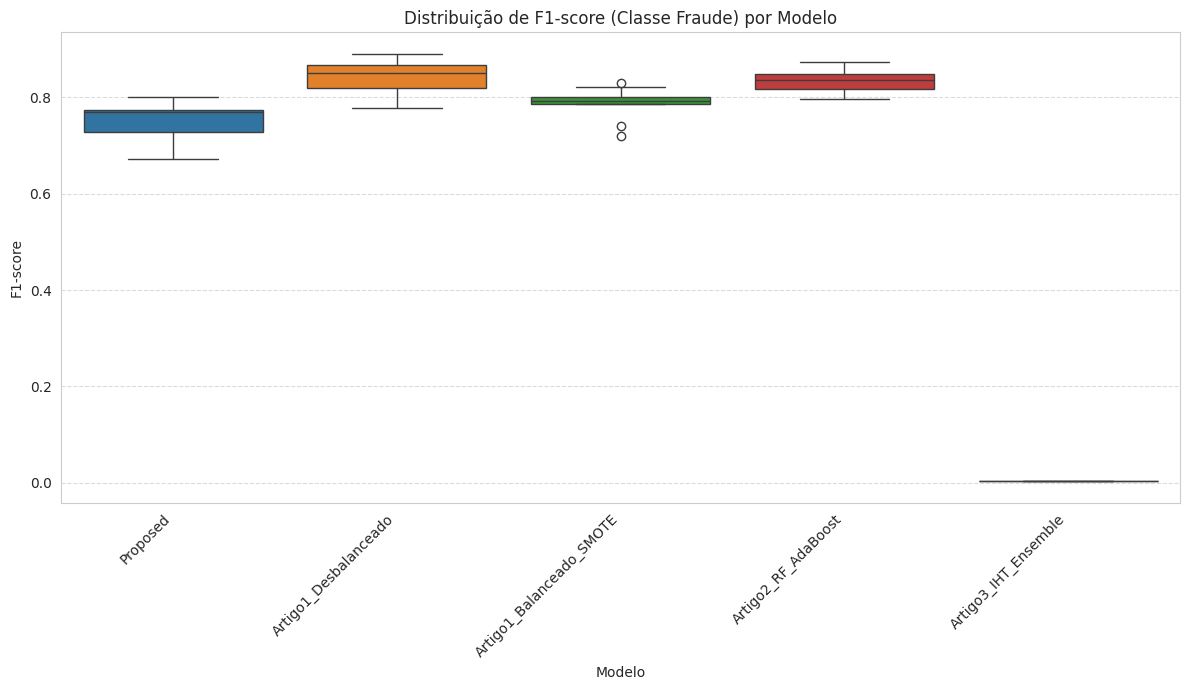

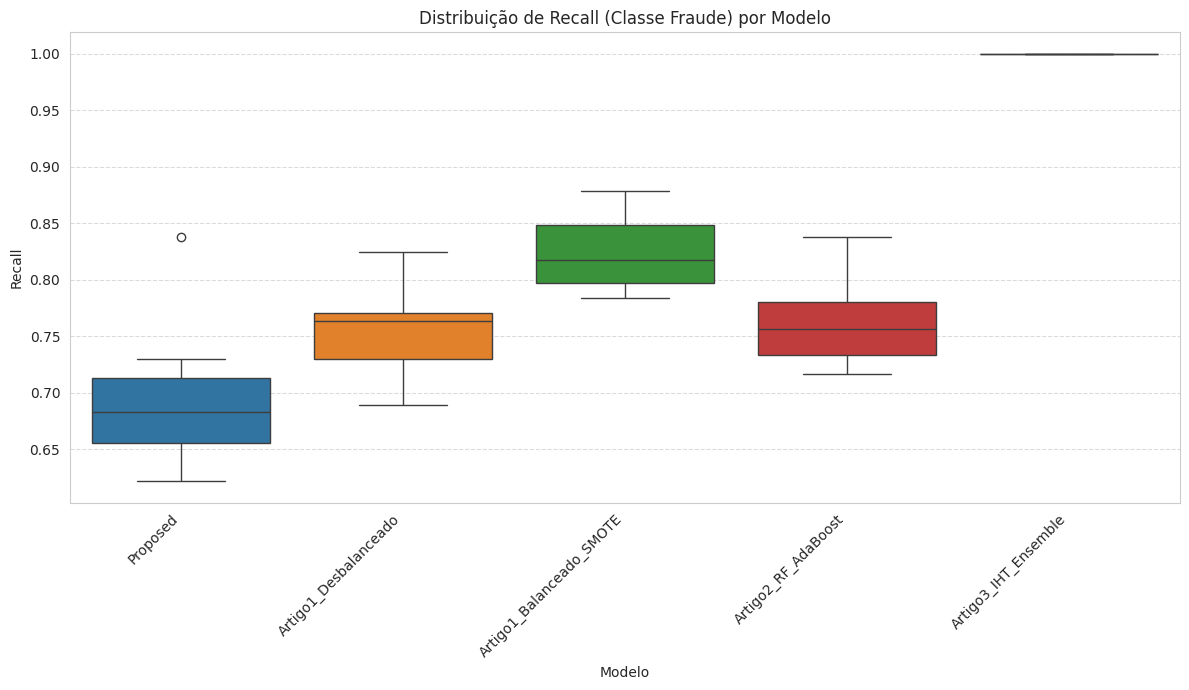

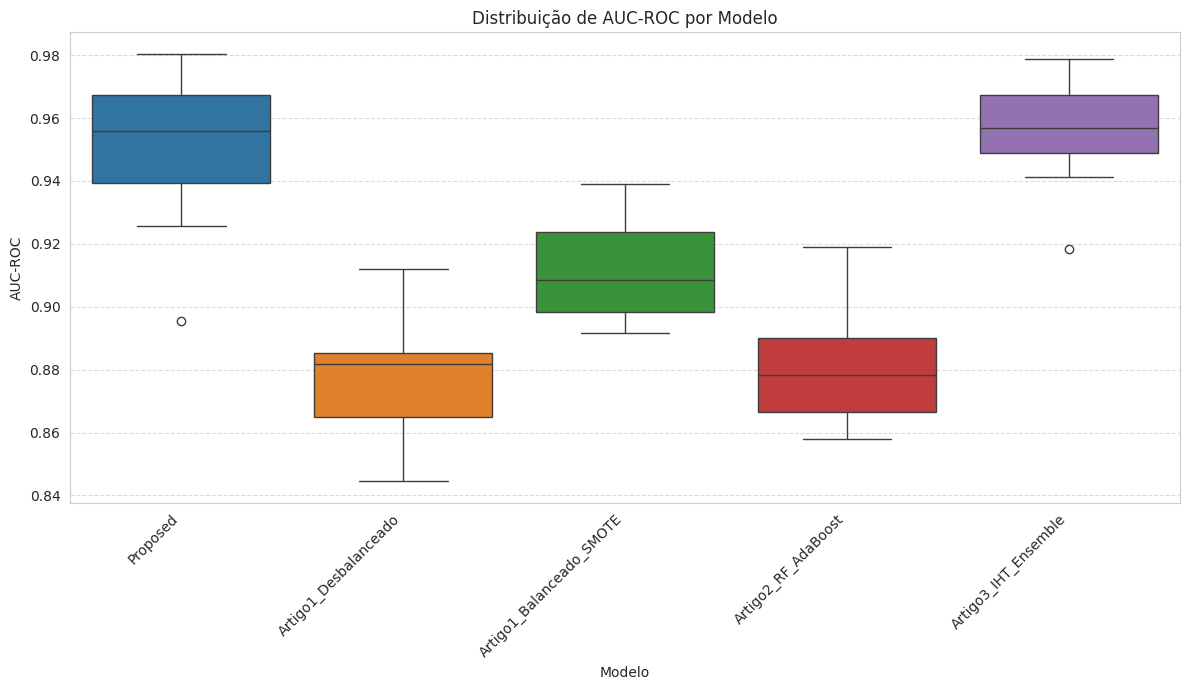

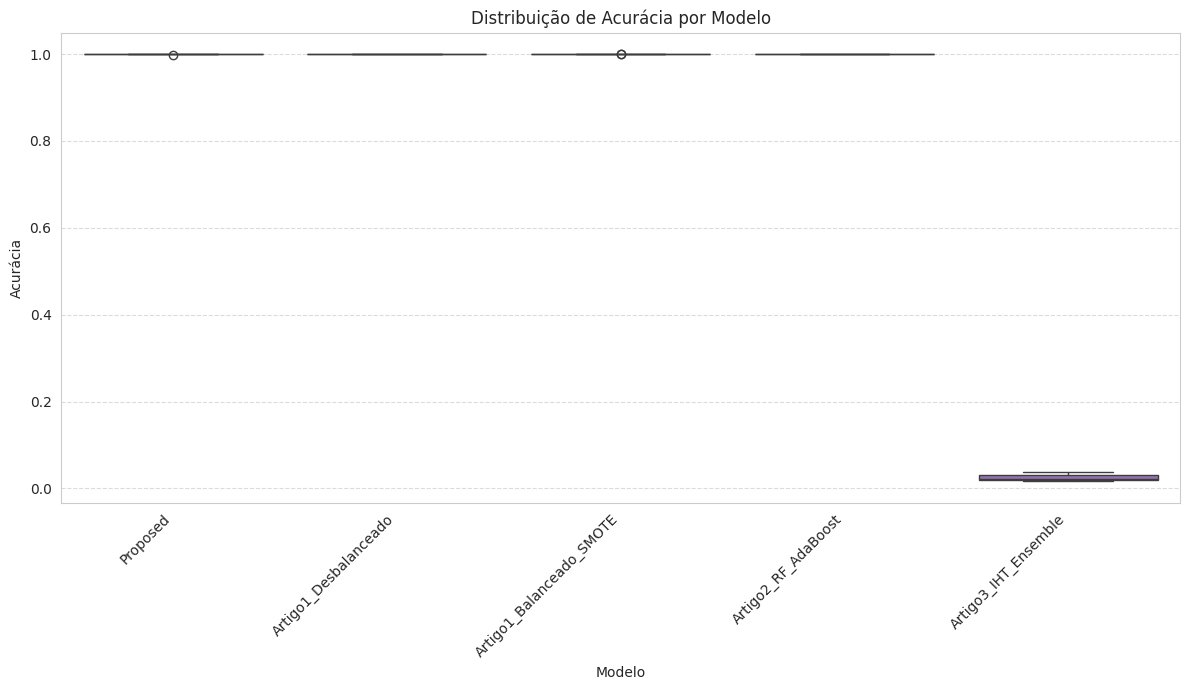

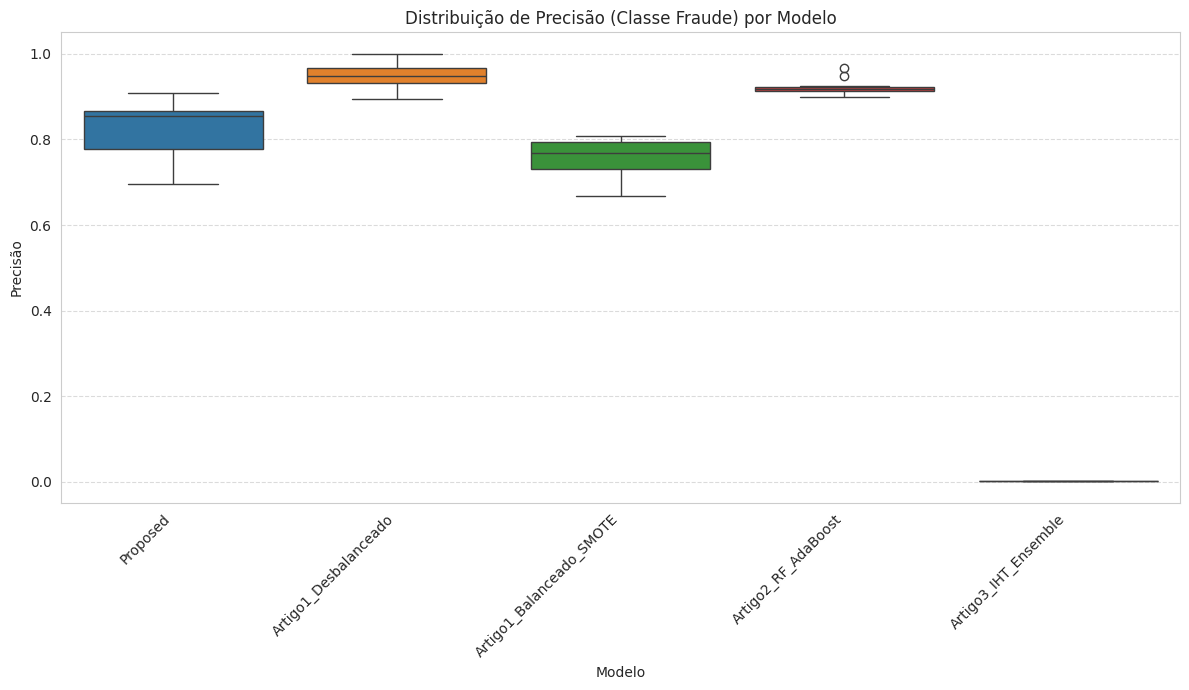

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings

# --- Configurações Iniciais ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_style('whitegrid')

# --- Bibliotecas de Machine Learning ---
# Pré-processamento e Pipelines
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import InstanceHardnessThreshold

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Validação e Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve

# Testes de Hipótese
from scipy import stats
from statsmodels.stats.contingency_tables import mcnemar

# =====================================================================================
# PASSO 0: CARREGAMENTO DO DATASET E PRÉ-PROCESSAMENTO GLOBAL
# =====================================================================================
print("PASSO 0: Carregando e aplicando pré-processamento global aos dados...")

# Download do dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
# print(f"Dataset baixado para: {path}")

try:
    df_raw = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
except FileNotFoundError:
    print("Erro: O arquivo 'creditcard.csv' não foi encontrado.")
    print("Por favor, verifique o caminho ou baixe-o via 'kagglehub.dataset_download'.")
    exit()

def global_preprocessing(data_frame):
    """
    Aplica engenharia de features cíclicas para 'Time' e normalização para 'Amount'.
    Retorna X e y processados.
    """
    df_processed = data_frame.copy()

    # Engenharia de Features Cíclicas para a coluna 'Time'
    seconds_in_day = 86400
    df_processed['time_sin'] = np.sin(2 * np.pi * df_processed['Time'] / seconds_in_day)
    df_processed['time_cos'] = np.cos(2 * np.pi * df_processed['Time'] / seconds_in_day)
    df_processed.drop('Time', axis=1, inplace=True)

    # Normalização da coluna 'Amount'
    scaler_amount = StandardScaler()
    df_processed['Amount'] = scaler_amount.fit_transform(df_processed['Amount'].values.reshape(-1, 1))

    X_proc = df_processed.drop("Class", axis=1)
    y_proc = df_processed["Class"]
    return X_proc, y_proc

# Chamando a função para criar as variáveis no escopo principal
X_original, y_original = global_preprocessing(df_raw.copy())

# =====================================================================================
# FUNÇÕES DE ENCAPSULAMENTO DOS MODELOS
# =====================================================================================

# --- Nosso Modelo Proposto: SVM-XGBoost em Cascata ---
def get_proposed_model_pipeline(X_train_data, y_train_data, X_val_data, y_val_data):
    """
    Retorna o pipeline completo do modelo proposto (SVM base + XGBoost meta-learner com SMOTE)
    e o melhor limiar de decisão otimizado no conjunto de validação.
    """
    # PASSO 3: Stacking (Modelo Base) - Gerando Features com SVM
    svm_base = SVC(C=10, gamma=0.01, kernel='rbf', probability=True, class_weight='balanced', random_state=42)

    # 1. Treinar SVM no treino completo para prever nos conjuntos de treino e validação
    svm_base.fit(X_train_data, y_train_data)
    svm_train_features = svm_base.predict_proba(X_train_data)
    svm_val_features = svm_base.predict_proba(X_val_data)

    # 3. Combinar as features originais com as novas features do SVM
    X_train_comb = np.hstack((X_train_data, svm_train_features))
    X_val_comb = np.hstack((X_val_data, svm_val_features))

    # PASSO 4: Treinamento do Meta-Learner (XGBoost com SMOTE)
    xgb_meta = XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=150,
                             learning_rate=0.1, max_depth=5, random_state=42)
    pipeline_final = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', xgb_meta)
    ])
    pipeline_final.fit(X_train_comb, y_train_data)

    # PASSO 5: Otimização do Limiar de Decisão
    y_val_proba = pipeline_final.predict_proba(X_val_comb)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val_data, y_val_proba)
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores)]

    return pipeline_final, best_threshold

# --- Modelo do Artigo 1: Ensemble Desbalanceado (sem SMOTE) e Balanceado (com SMOTE) ---
# Esta função retorna um dicionário de modelos, um para cada abordagem
def get_artigo1_models():
    lr_clf_imb = LogisticRegression(random_state=42, solver='liblinear', class_weight=None)
    xgb_clf_imb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    mlp_clf_imb = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)

    # Ensemble Desbalanceado (voting='hard' como no artigo)
    ensemble_imb = VotingClassifier(
        estimators=[('lr', lr_clf_imb), ('xgb', xgb_clf_imb), ('mlp', mlp_clf_imb)],
        voting='hard'
    )

    # Pipelines para o cenário balanceado (SMOTE)
    lr_pipe_bal = ImbPipeline([('smote', SMOTE(random_state=42)), ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])
    xgb_pipe_bal = ImbPipeline([('smote', SMOTE(random_state=42)), ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])
    mlp_pipe_bal = ImbPipeline([('smote', SMOTE(random_state=42)), ('classifier', MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42))])

    # Ensemble Balanceado (voting='hard' como no artigo)
    ensemble_bal = VotingClassifier(
        estimators=[('lr_pipe', lr_pipe_bal), ('xgb_pipe', xgb_pipe_bal), ('mlp_pipe', mlp_pipe_bal)],
        voting='hard'
    )
    return {'Artigo1_Desbalanceado': ensemble_imb, 'Artigo1_Balanceado_SMOTE': ensemble_bal}

# --- Modelo do Artigo 2: Híbrido RF-AdaBoost ---
def get_artigo2_model(X_train_data, y_train_data):
    """
    Retorna o modelo híbrido RF-AdaBoost treinado.
    O SMOTE é aplicado antes do treinamento aqui, como no artigo.
    """
    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train_data, y_train_data)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    ada = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=42)

    rf.fit(X_train_sm, y_train_sm)
    rf_preds_train = rf.predict_proba(X_train_sm)[:, 1].reshape(-1, 1)
    ada.fit(rf_preds_train, y_train_sm)

    # Retorna o RF e o AdaBoost separadamente para uso na predição
    return rf, ada

# --- Modelo do Artigo 3: Ensemble IHT-LR com Grid Search ---
# A busca por melhores pesos será feita UMA VEZ no início
best_weights_artigo3 = None
def optimize_artigo3_weights_once(X_full, y_full):
    """
    Realiza o GridSearchCV para encontrar os melhores pesos para o VotingClassifier
    do Artigo 3, executado apenas uma vez.
    """
    global best_weights_artigo3
    if best_weights_artigo3 is not None:
        return best_weights_artigo3

    print("\nOtimizando pesos para o modelo do Artigo 3 (GridSearch)...")

    # Aqui, como precisamos usar o X e y no formato que o Artigo 3 espera, que é scaled mas antes da sua engenharia de features cíclicas.
    # Para ser consistente com o resto do código, usaremos X_full e y_full já processados globalmente.
    # No Artigo 3, eles aplicam StandardScaler em todas as features.

    # Re-escalar X_full para aderir ao preprocessing original do Artigo 3 (sem features cíclicas para o GridSearch)
    temp_df = df_raw.copy()
    temp_df.drop('Class', axis=1, inplace=True)
    scaler_artigo3 = StandardScaler()
    X_scaled_artigo3 = scaler_artigo3.fit_transform(temp_df)
    y_enc_artigo3 = y_full

    # IHT-LR como no artigo
    lr_iht = LogisticRegression(max_iter=1000, random_state=42)
    iht = InstanceHardnessThreshold(estimator=lr_iht, sampling_strategy='majority', random_state=42)
    X_bal, y_bal = iht.fit_resample(X_scaled_artigo3, y_enc_artigo3)

    models_artigo3 = {
        'dt': DecisionTreeClassifier(random_state=42),
        'rf': RandomForestClassifier(n_estimators=100, random_state=42),
        'knn': KNeighborsClassifier(),
        'mlp': MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, random_state=42)
    }

    ensemble_artigo3 = VotingClassifier(
        estimators=[(k, v) for k, v in models_artigo3.items()],
        voting='hard',
        weights=[0.25, 0.25, 0.25, 0.25]
    )

    param_grid = {
        'weights': [
            [0.25, 0.25, 0.25, 0.25],
            [0.4, 0.3, 0.2, 0.1],
            [0.1, 0.2, 0.3, 0.4],
            [0.3, 0.3, 0.2, 0.2],
            [0.2, 0.2, 0.3, 0.3]
        ]
    }

    cv_grid = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Reduzindo n_splits para agilizar
    grid = GridSearchCV(ensemble_artigo3, param_grid, cv=cv_grid, scoring='roc_auc', n_jobs=-1, verbose=0)
    grid.fit(X_bal, y_bal)
    best_weights_artigo3 = grid.best_params_['weights']
    print(f"Melhores pesos para Artigo 3 encontrados: {best_weights_artigo3}")
    print(f"Melhor AUC com esses pesos (GridSearch): {grid.best_score_:.4f}\n")
    return best_weights_artigo3

# Chamar a otimização de pesos uma vez no início
optimize_artigo3_weights_once(X_original, y_original)

def get_artigo3_model(X_train_data, y_train_data, best_weights):
    """
    Retorna o modelo do Artigo 3 treinado com os melhores pesos encontrados
    e aplica IHT-LR nos dados de treino.
    """
    # Instanciamos IHT-LR para o split atual de treino
    lr_iht = LogisticRegression(max_iter=1000, random_state=42)
    iht = InstanceHardnessThreshold(estimator=lr_iht, sampling_strategy='majority', random_state=42)
    X_train_bal, y_train_bal = iht.fit_resample(X_train_data, y_train_data)

    models_artigo3_inner = {
        'dt': DecisionTreeClassifier(random_state=42),
        'rf': RandomForestClassifier(n_estimators=100, random_state=42),
        'knn': KNeighborsClassifier(),
        'mlp': MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, random_state=42)
    }

    ensemble_artigo3_final = VotingClassifier(
        estimators=[(k, v) for k, v in models_artigo3_inner.items()],
        voting='soft',
        weights=best_weights
    )
    ensemble_artigo3_final.fit(X_train_bal, y_train_bal)
    return ensemble_artigo3_final

# =====================================================================================
# SIMULAÇÃO MÚLTIPLA E COLETA DE MÉTRICAS
# =====================================================================================
N_RUNS = 10

# Dicionários para armazenar resultados de cada modelo
results_f1 = {'Proposed': [], 'Artigo1_Desbalanceado': [], 'Artigo1_Balanceado_SMOTE': [],
              'Artigo2_RF_AdaBoost': [], 'Artigo3_IHT_Ensemble': []}
results_recall = {k: [] for k in results_f1.keys()}
results_auc_roc = {k: [] for k in results_f1.keys()}
results_accuracy = {k: [] for k in results_f1.keys()}
results_precision = {k: [] for k in results_f1.keys()}

# Para McNemar, precisamos das predições binárias por execução
predictions_for_mcnemar = [] # Lista de tuplas: (y_true_test, y_pred_model1, y_pred_model2, ...)

print(f"\nIniciando {N_RUNS} execuções para coleta de métricas...")

for i in range(N_RUNS):
    print(f"\n--- Execução {i+1}/{N_RUNS} ---")

    # Divisão Estratificada (garantindo que cada run seja independente)
    # Primeiro, dividimos em treino (70%) e um conjunto temporário (30%)
    X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
        df_raw.drop("Class", axis=1), df_raw["Class"], test_size=0.3, stratify=df_raw["Class"], random_state=42 + i
    )

    # Dividimos o conjunto temporário igualmente em validação e teste (15% cada do total)
    X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
        X_temp_raw, y_temp_raw, test_size=0.5, stratify=y_temp_raw, random_state=42 + i
    )

    # Aplicando pré-processamento global para o split atual
    X_train_proc, y_train_proc = global_preprocessing(pd.concat([X_train_raw, y_train_raw], axis=1))
    X_val_proc, y_val_proc = global_preprocessing(pd.concat([X_val_raw, y_val_raw], axis=1))
    X_test_proc, y_test_proc = global_preprocessing(pd.concat([X_test_raw, y_test_raw], axis=1))

    # --- 1. Treinar e Avaliar Seu Modelo Proposto ---
    print("  Treinando e avaliando Modelo Proposto...")
    start_time = time()
    model_proposed_pipeline, best_threshold_proposed = get_proposed_model_pipeline(X_train_proc, y_train_proc, X_val_proc, y_val_proc)

    # Preparar X_test_comb para o modelo proposto
    # Re-treinar SVM base no treino_proc para prever no teste_proc
    svm_temp = SVC(C=10, gamma=0.01, kernel='rbf', probability=True, class_weight='balanced', random_state=42)
    svm_temp.fit(X_train_proc, y_train_proc)
    svm_test_features_proposed = svm_temp.predict_proba(X_test_proc)
    X_test_comb_proposed = np.hstack((X_test_proc, svm_test_features_proposed))

    y_proba_proposed = model_proposed_pipeline.predict_proba(X_test_comb_proposed)[:, 1]
    y_pred_proposed = (y_proba_proposed >= best_threshold_proposed).astype(int)

    results_f1['Proposed'].append(f1_score(y_test_proc, y_pred_proposed, pos_label=1))
    results_recall['Proposed'].append(recall_score(y_test_proc, y_pred_proposed, pos_label=1))
    results_auc_roc['Proposed'].append(roc_auc_score(y_test_proc, y_proba_proposed))
    results_accuracy['Proposed'].append(accuracy_score(y_test_proc, y_pred_proposed))
    results_precision['Proposed'].append(precision_score(y_test_proc, y_pred_proposed, pos_label=1))
    print(f"  Modelo Proposto concluído em {time() - start_time:.2f}s")

    # --- 2. Treinar e Avaliar Modelos do Artigo 1 ---
    print("  Treinando e avaliando Modelos do Artigo 1...")
    start_time = time()
    artigo1_models = get_artigo1_models()
    for name, model_artigo1 in artigo1_models.items():
        model_artigo1.fit(X_train_proc, y_train_proc)
        y_pred_artigo1 = model_artigo1.predict(X_test_proc)
        y_proba_artigo1 = model_artigo1.predict_proba(X_test_proc)[:, 1] if hasattr(model_artigo1, 'predict_proba') else y_pred_artigo1 # Fallback for hard voting

        results_f1[name].append(f1_score(y_test_proc, y_pred_artigo1, pos_label=1))
        results_recall[name].append(recall_score(y_test_proc, y_pred_artigo1, pos_label=1))
        results_auc_roc[name].append(roc_auc_score(y_test_proc, y_proba_artigo1))
        # Adicionando acurácia e precisão
        results_accuracy[name].append(accuracy_score(y_test_proc, y_pred_artigo1))
        results_precision[name].append(precision_score(y_test_proc, y_pred_artigo1, pos_label=1))
    print(f"  Modelos do Artigo 1 concluídos em {time() - start_time:.2f}s")

    # --- 3. Treinar e Avaliar Modelo do Artigo 2 (RF-AdaBoost) ---
    print("  Treinando e avaliando Modelo do Artigo 2...")
    start_time = time()
    rf_artigo2, ada_artigo2 = get_artigo2_model(X_train_proc, y_train_proc)

    rf_preds_test_artigo2 = rf_artigo2.predict_proba(X_test_proc)[:, 1].reshape(-1, 1)
    y_pred_artigo2 = ada_artigo2.predict(rf_preds_test_artigo2)
    # AUC para o Artigo 2 precisa de probabilidades do AdaBoost
    # Aqui, usaremos a probabilidade do AdaBoost, se disponível
    y_proba_artigo2 = ada_artigo2.predict_proba(rf_preds_test_artigo2)[:, 1] if hasattr(ada_artigo2, 'predict_proba') else y_pred_artigo2

    results_f1['Artigo2_RF_AdaBoost'].append(f1_score(y_test_proc, y_pred_artigo2, pos_label=1))
    results_recall['Artigo2_RF_AdaBoost'].append(recall_score(y_test_proc, y_pred_artigo2, pos_label=1))
    results_auc_roc['Artigo2_RF_AdaBoost'].append(roc_auc_score(y_test_proc, y_proba_artigo2))
    # Adicionando acurácia e precisão
    results_accuracy['Artigo2_RF_AdaBoost'].append(accuracy_score(y_test_proc, y_pred_artigo2))
    results_precision['Artigo2_RF_AdaBoost'].append(precision_score(y_test_proc, y_pred_artigo2, pos_label=1))
    print(f"  Modelo do Artigo 2 concluído em {time() - start_time:.2f}s")

    # --- 4. Treinar e Avaliar Modelo do Artigo 3 (IHT-LR Ensemble) ---
    print("  Treinando e avaliando Modelo do Artigo 3...")
    start_time = time()
    model_artigo3 = get_artigo3_model(X_train_proc, y_train_proc, best_weights_artigo3)
    y_pred_artigo3 = model_artigo3.predict(X_test_proc)
    y_proba_artigo3 = model_artigo3.predict_proba(X_test_proc)[:, 1]

    results_f1['Artigo3_IHT_Ensemble'].append(f1_score(y_test_proc, y_pred_artigo3, pos_label=1))
    results_recall['Artigo3_IHT_Ensemble'].append(recall_score(y_test_proc, y_pred_artigo3, pos_label=1))
    results_auc_roc['Artigo3_IHT_Ensemble'].append(roc_auc_score(y_test_proc, y_proba_artigo3))
    # Adicionando acurácia e precisão
    results_accuracy['Artigo3_IHT_Ensemble'].append(accuracy_score(y_test_proc, y_pred_artigo3))
    results_precision['Artigo3_IHT_Ensemble'].append(precision_score(y_test_proc, y_pred_artigo3, pos_label=1))
    print(f"  Modelo do Artigo 3 concluído em {time() - start_time:.2f}s")

    # Coletar predições binárias para o Teste de McNemar
    # A ordem das predições: Proposed, Artigo1_Desbalanceado, Artigo1_Balanceado_SMOTE, Artigo2, Artigo3
    predictions_for_mcnemar.append([
        y_test_proc.values,
        y_pred_proposed,
        y_pred_artigo1,
        y_pred_artigo2,
        y_pred_artigo3
    ])

# =====================================================================================
# SIMULAÇÃO MÚLTIPLA E COLETA DE MÉTRICAS (REVISADA)
# =====================================================================================
N_RUNS = 10

# Dicionários para armazenar resultados de cada modelo
results_f1 = {'Proposed': [], 'Artigo1_Desbalanceado': [], 'Artigo1_Balanceado_SMOTE': [],
              'Artigo2_RF_AdaBoost': [], 'Artigo3_IHT_Ensemble': []}
results_recall = {k: [] for k in results_f1.keys()}
results_auc_roc = {k: [] for k in results_f1.keys()}
results_accuracy = {k: [] for k in results_f1.keys()}
results_precision = {k: [] for k in results_f1.keys()}

predictions_for_mcnemar = [] # Lista de tuplas: (y_true_test, y_pred_model1, y_pred_model2, ...)

print(f"\nIniciando {N_RUNS} execuções para coleta de métricas...")

for i in range(N_RUNS):
    print(f"\n--- Execução {i+1}/{N_RUNS} ---")

    X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
        df_raw.drop("Class", axis=1), df_raw["Class"], test_size=0.3, stratify=df_raw["Class"], random_state=42 + i
    )
    X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
        X_temp_raw, y_temp_raw, test_size=0.5, stratify=y_temp_raw, random_state=42 + i
    )

    X_train_proc, y_train_proc = global_preprocessing(pd.concat([X_train_raw, y_train_raw], axis=1))
    X_val_proc, y_val_proc = global_preprocessing(pd.concat([X_val_raw, y_val_raw], axis=1))
    X_test_proc, y_test_proc = global_preprocessing(pd.concat([X_test_raw, y_test_raw], axis=1))

    # --- 1. Treinar e Avaliar Seu Modelo Proposto ---
    print("  Treinando e avaliando Modelo Proposto...")
    start_time = time()
    model_proposed_pipeline, best_threshold_proposed = get_proposed_model_pipeline(X_train_proc, y_train_proc, X_val_proc, y_val_proc)

    svm_temp = SVC(C=10, gamma=0.01, kernel='rbf', probability=True, class_weight='balanced', random_state=42)
    svm_temp.fit(X_train_proc, y_train_proc)
    svm_test_features_proposed = svm_temp.predict_proba(X_test_proc)
    X_test_comb_proposed = np.hstack((X_test_proc, svm_test_features_proposed))

    y_proba_proposed = model_proposed_pipeline.predict_proba(X_test_comb_proposed)[:, 1]
    y_pred_proposed = (y_proba_proposed >= best_threshold_proposed).astype(int)

    results_f1['Proposed'].append(f1_score(y_test_proc, y_pred_proposed, pos_label=1))
    results_recall['Proposed'].append(recall_score(y_test_proc, y_pred_proposed, pos_label=1))
    results_auc_roc['Proposed'].append(roc_auc_score(y_test_proc, y_proba_proposed))
    results_accuracy['Proposed'].append(accuracy_score(y_test_proc, y_pred_proposed))
    results_precision['Proposed'].append(precision_score(y_test_proc, y_pred_proposed, pos_label=1))
    print(f"  Modelo Proposto concluído em {time() - start_time:.2f}s")

    # --- 2. Treinar e Avaliar Modelos do Artigo 1 ---
    print("  Treinando e avaliando Modelos do Artigo 1...")
    start_time = time()
    artigo1_models = get_artigo1_models()

    y_pred_artigo1_desbalanceado = None # Inicializa para capturar
    y_pred_artigo1_balanceado_smote = None # Inicializa para capturar

    for name, model_artigo1 in artigo1_models.items():
        model_artigo1.fit(X_train_proc, y_train_proc)
        y_pred_artigo1 = model_artigo1.predict(X_test_proc)
        y_proba_artigo1 = model_artigo1.predict_proba(X_test_proc)[:, 1] if hasattr(model_artigo1, 'predict_proba') else y_pred_artigo1

        results_f1[name].append(f1_score(y_test_proc, y_pred_artigo1, pos_label=1))
        results_recall[name].append(recall_score(y_test_proc, y_pred_artigo1, pos_label=1))
        results_auc_roc[name].append(roc_auc_score(y_test_proc, y_proba_artigo1))
        results_accuracy[name].append(accuracy_score(y_test_proc, y_pred_artigo1))
        results_precision[name].append(precision_score(y_test_proc, y_pred_artigo1, pos_label=1))

        if name == 'Artigo1_Desbalanceado':
            y_pred_artigo1_desbalanceado = y_pred_artigo1
        elif name == 'Artigo1_Balanceado_SMOTE':
            y_pred_artigo1_balanceado_smote = y_pred_artigo1

    print(f"  Modelos do Artigo 1 concluídos em {time() - start_time:.2f}s")

    # --- 3. Treinar e Avaliar Modelo do Artigo 2 (RF-AdaBoost) ---
    print("  Treinando e avaliando Modelo do Artigo 2...")
    start_time = time()
    rf_artigo2, ada_artigo2 = get_artigo2_model(X_train_proc, y_train_proc)

    rf_preds_test_artigo2 = rf_artigo2.predict_proba(X_test_proc)[:, 1].reshape(-1, 1)
    y_pred_artigo2 = ada_artigo2.predict(rf_preds_test_artigo2)
    y_proba_artigo2 = ada_artigo2.predict_proba(rf_preds_test_artigo2)[:, 1] if hasattr(ada_artigo2, 'predict_proba') else y_pred_artigo2

    results_f1['Artigo2_RF_AdaBoost'].append(f1_score(y_test_proc, y_pred_artigo2, pos_label=1))
    results_recall['Artigo2_RF_AdaBoost'].append(recall_score(y_test_proc, y_pred_artigo2, pos_label=1))
    results_auc_roc['Artigo2_RF_AdaBoost'].append(roc_auc_score(y_test_proc, y_proba_artigo2))
    results_accuracy['Artigo2_RF_AdaBoost'].append(accuracy_score(y_test_proc, y_pred_artigo2))
    results_precision['Artigo2_RF_AdaBoost'].append(precision_score(y_test_proc, y_pred_artigo2, pos_label=1))
    print(f"  Modelo do Artigo 2 concluído em {time() - start_time:.2f}s")

    # --- 4. Treinar e Avaliar Modelo do Artigo 3 (IHT-LR Ensemble) ---
    print("  Treinando e avaliando Modelo do Artigo 3...")
    start_time = time()
    model_artigo3 = get_artigo3_model(X_train_proc, y_train_proc, best_weights_artigo3)
    y_pred_artigo3 = model_artigo3.predict(X_test_proc)
    y_proba_artigo3 = model_artigo3.predict_proba(X_test_proc)[:, 1]

    results_f1['Artigo3_IHT_Ensemble'].append(f1_score(y_test_proc, y_pred_artigo3, pos_label=1))
    results_recall['Artigo3_IHT_Ensemble'].append(recall_score(y_test_proc, y_pred_artigo3, pos_label=1))
    results_auc_roc['Artigo3_IHT_Ensemble'].append(roc_auc_score(y_test_proc, y_proba_artigo3))
    results_accuracy['Artigo3_IHT_Ensemble'].append(accuracy_score(y_test_proc, y_pred_artigo3))
    results_precision['Artigo3_IHT_Ensemble'].append(precision_score(y_test_proc, y_pred_artigo3, pos_label=1))
    print(f"  Modelo do Artigo 3 concluído em {time() - start_time:.2f}s")

    # Coletar predições binárias para o Teste de McNemar
    predictions_for_mcnemar.append([
        y_test_proc.values,
        y_pred_proposed,
        y_pred_artigo1_desbalanceado,
        y_pred_artigo1_balanceado_smote,
        y_pred_artigo2,
        y_pred_artigo3
    ])

# =====================================================================================
# ANÁLISE ESTATÍSTICA E VISUALIZAÇÃO DOS RESULTADOS
# =====================================================================================
print("\n" + "=" * 50)
print("==== RESULTADOS FINAIS E ANÁLISE ESTATÍSTICA ====")
print("=" * 50 + "\n")

# --- 1. Apresentação das Médias e Desvios Padrão ---
print("==== MÉDIAS E DESVIOS PADRÃO DAS MÉTRICAS (AO LONHO DE %d EXECUÇÕES) ====" % N_RUNS)
all_results = {
    'Accuracy': results_accuracy,
    'Precision': results_precision,
    'F1-score': results_f1,
    'Recall': results_recall,
    'AUC-ROC': results_auc_roc
}

results_summary_df = pd.DataFrame(columns=['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'AUC-ROC'])

for model_name in results_f1.keys():
    mean_accuracy = np.mean(results_accuracy[model_name])
    std_accuracy = np.std(results_accuracy[model_name])
    mean_precision = np.mean(results_precision[model_name])
    std_precision = np.std(results_precision[model_name])
    mean_recall = np.mean(results_recall[model_name])
    std_recall = np.std(results_recall[model_name])
    mean_f1 = np.mean(results_f1[model_name])
    std_f1 = np.std(results_f1[model_name])
    mean_auc = np.mean(results_auc_roc[model_name])
    std_auc = np.std(results_auc_roc[model_name])

    results_summary_df.loc[model_name] = [
        f"{mean_accuracy:.4f} ± {std_accuracy:.4f}",
        f"{mean_precision:.4f} ± {std_precision:.4f}",
        f"{mean_recall:.4f} ± {std_recall:.4f}",
        f"{mean_f1:.4f} ± {std_f1:.4f}",
        f"{mean_auc:.4f} ± {std_auc:.4f}"
    ]

print(results_summary_df.to_string())

# --- 2. Testes de Hipótese (p-values) ---
print("\n==== TESTES DE HIPÓTESE (p-values) ====")
alpha = 0.05

models_to_compare_against_proposed = [
    'Artigo1_Desbalanceado',
    'Artigo1_Balanceado_SMOTE',
    'Artigo2_RF_AdaBoost',
    'Artigo3_IHT_Ensemble'
]

for metric_name, results_data_dict in all_results.items():
    print(f"\n--- Comparação para {metric_name} ---")
    scores_proposed = results_data_dict['Proposed']

    for ref_model_name in models_to_compare_against_proposed:
        scores_ref = results_data_dict[ref_model_name]

        # Teste T Pareado
        if np.std(scores_proposed) == 0 and np.std(scores_ref) == 0 and np.mean(scores_proposed) == np.mean(scores_ref):
             p_val_t = 1.0
        else:
            t_stat, p_val_t = stats.ttest_rel(scores_proposed, scores_ref)
        print(f"  Proposto vs {ref_model_name} (Teste T Pareado): p-value = {p_val_t:.4f} ({'Significativo' if p_val_t < alpha else 'Não Significativo'})")

        # Teste Wilcoxon Signed-Rank
        try:
            w_stat, p_val_w = stats.wilcoxon(scores_proposed, scores_ref)
        except ValueError:
            p_val_w = 1.0
        print(f"  Proposto vs {ref_model_name} (Wilcoxon Signed-Rank): p-value = {p_val_w:.4f} ({'Significativo' if p_val_w < alpha else 'Não Significativo'})")

print("\n--- Teste de McNemar (Proporção de execuções significativas) ---")
mcnemar_significant_counts = {name: 0 for name in models_to_compare_against_proposed}

for run_data in predictions_for_mcnemar:
    y_true_run = run_data[0]
    y_pred_proposed_run = run_data[1]

    # Mapeamento corrigido para os modelos de referência em `run_data`
    y_preds_ref_runs = {
        'Artigo1_Desbalanceado': run_data[2],
        'Artigo1_Balanceado_SMOTE': run_data[3],
        'Artigo2_RF_AdaBoost': run_data[4],
        'Artigo3_IHT_Ensemble': run_data[5]
    }

    for ref_model_name in models_to_compare_against_proposed:
        y_pred_ref_run = y_preds_ref_runs[ref_model_name]

        case_ci = ((y_pred_proposed_run == y_true_run) & (y_pred_ref_run != y_true_run)).sum()
        case_ic = ((y_pred_proposed_run != y_true_run) & (y_pred_ref_run == y_true_run)).sum()

        if case_ci + case_ic == 0:
            p_val_mcnemar = 1.0
        else:
            table = np.array([[0, case_ic], [case_ci, 0]])
            result = mcnemar(table, exact=True)
            p_val_mcnemar = result.pvalue

        if p_val_mcnemar < alpha:
            mcnemar_significant_counts[ref_model_name] += 1

for ref_model_name, count in mcnemar_significant_counts.items():
    print(f"  Proposto vs {ref_model_name} (McNemar): Significativo em {count}/{N_RUNS} execuções ({count/N_RUNS*100:.2f}%)")

# --- 3. Visualização dos Resultados (Box Plots) ---
print("\n==== VISUALIZAÇÃO DOS RESULTADOS ====")

# Box Plots para F1-score
data_f1 = pd.DataFrame(results_f1)
plt.figure(figsize=(12, 7))
sns.boxplot(data=data_f1)
plt.title('Distribuição de F1-score (Classe Fraude) por Modelo')
plt.ylabel('F1-score')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Box Plots para Recall
data_recall = pd.DataFrame(results_recall)
plt.figure(figsize=(12, 7))
sns.boxplot(data=data_recall)
plt.title('Distribuição de Recall (Classe Fraude) por Modelo')
plt.ylabel('Recall')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Box Plots para AUC-ROC
data_auc_roc = pd.DataFrame(results_auc_roc)
plt.figure(figsize=(12, 7))
sns.boxplot(data=data_auc_roc)
plt.title('Distribuição de AUC-ROC por Modelo')
plt.ylabel('AUC-ROC')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Box Plots para Acurácia (NOVO)
data_accuracy = pd.DataFrame(results_accuracy)
plt.figure(figsize=(12, 7))
sns.boxplot(data=data_accuracy)
plt.title('Distribuição de Acurácia por Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Box Plots para Precisão (NOVO)
data_precision = pd.DataFrame(results_precision)
plt.figure(figsize=(12, 7))
sns.boxplot(data=data_precision)
plt.title('Distribuição de Precisão (Classe Fraude) por Modelo')
plt.ylabel('Precisão')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()